In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


In [45]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
# every element in the dataset is a batch of 32 images
# In machine learning and deep learning, a dataset is a collection of data points that are used to train or test a machine learning model.

# When working with large datasets, it's often necessary to break the data up into smaller batches to make it more manageable for the computer to process.

# In the context of your question, a dataset with a batch of 32 images means that the dataset has been organized into groups of 32 images each.

# This is often done to facilitate training a machine learning model
# in a process known as "mini-batch training". 
# In mini-batch training, the model is trained on smaller batches 
# of data rather than the entire dataset at once. 
# This can speed up the training process and make it more memory-efficient.

# So, if you were working with a dataset of 1000 images and you organized it into batches of 32, you would end up with 32 batches of 32 images each, and one final batch of 24 images.
len(dataset)

68

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    
# 32 images
# each image is 256x256
# with 3 RGB channels 

(32, 256, 256, 3)
[1 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 2 1 0 0 2 0 0 0 0 1 1 0 0 0 1 0]


In [7]:
for image_batch, label_batch in dataset.take(1):
    # print the first image of 32 images
    print(image_batch[0].numpy())
    # 3D arrays , the color is represented by a number between 0 and 255

[[[170. 165. 169.]
  [159. 154. 158.]
  [153. 148. 152.]
  ...
  [184. 177. 193.]
  [187. 180. 198.]
  [193. 185. 206.]]

 [[153. 148. 152.]
  [152. 147. 151.]
  [152. 147. 151.]
  ...
  [200. 194. 206.]
  [193. 187. 201.]
  [185. 178. 194.]]

 [[154. 149. 153.]
  [159. 154. 158.]
  [157. 152. 156.]
  ...
  [200. 198. 203.]
  [193. 190. 197.]
  [180. 177. 184.]]

 ...

 [[149. 143. 155.]
  [151. 145. 157.]
  [157. 151. 161.]
  ...
  [191. 188. 195.]
  [183. 180. 187.]
  [181. 178. 185.]]

 [[138. 132. 146.]
  [141. 135. 147.]
  [144. 138. 148.]
  ...
  [182. 179. 186.]
  [175. 172. 179.]
  [177. 174. 181.]]

 [[156. 150. 164.]
  [165. 159. 171.]
  [163. 157. 169.]
  ...
  [186. 183. 190.]
  [180. 177. 184.]
  [187. 184. 191.]]]


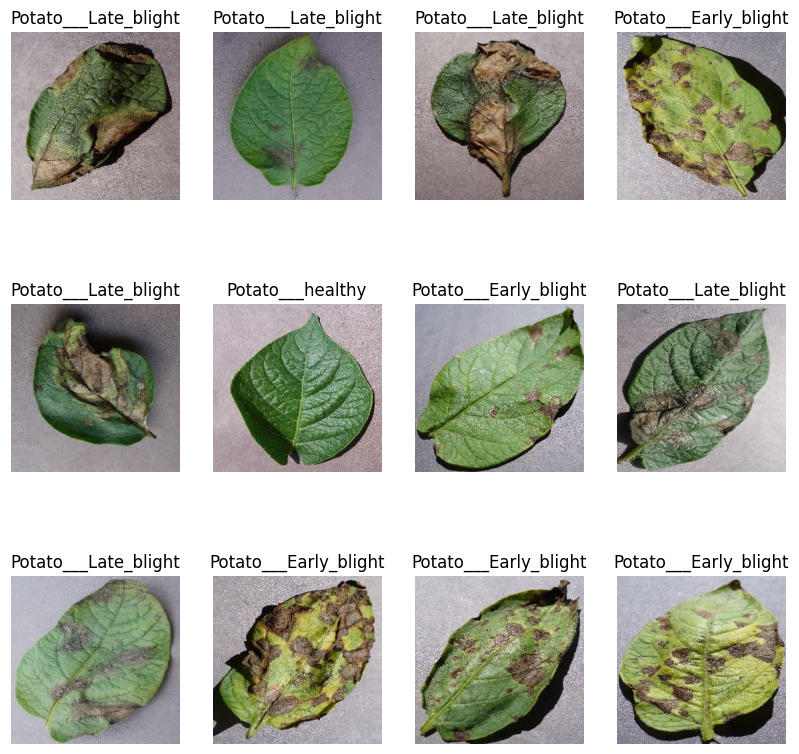

In [8]:
# VISULIZE IMAGE
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [9]:
len(dataset)

68

In [10]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [11]:
train_ds = dataset.take(54)
len(train_ds)

54

In [12]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [13]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [14]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [15]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

54

In [19]:
len(val_ds)

6

In [20]:
len(test_ds)

8

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [23]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [24]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [27]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [28]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 213s 3s/step - loss: 0.9230 - accuracy: 0.4850 - val_loss: 0.8887 - val_accuracy: 0.5521
Epoch 2/50
54/54 [==============================] - 173s 3s/step - loss: 0.7864 - accuracy: 0.6175 - val_loss: 1.2593 - val_accuracy: 0.6198
Epoch 3/50
54/54 [==============================] - 219s 4s/step - loss: 0.5764 - accuracy: 0.7517 - val_loss: 0.3775 - val_accuracy: 0.8750
Epoch 4/50
54/54 [==============================] - 230s 4s/step - loss: 0.3747 - accuracy: 0.8519 - val_loss: 0.3484 - val_accuracy: 0.8958
Epoch 5/50
54/54 [==============================] - 223s 4s/step - loss: 0.3134 - accuracy: 0.8866 - val_loss: 0.3656 - val_accuracy: 0.8594
Epoch 6/50
54/54 [==============================] - 210s 4s/step - loss: 0.2811 - accuracy: 0.8912 - val_loss: 0.1471 - val_accuracy: 0.9375
Epoch 7/50
54/54 [==============================] - 223s 4s/step - loss: 0.2183 - accuracy: 0.9219 - val_loss: 0.1457 - val_accuracy: 0.9427
Epoch 8/50
54

In [36]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 6s 700ms/step - loss: 0.0460 - accuracy: 0.9766


In [37]:
scores

[0.04601215571165085, 0.9765625]

In [38]:
history

In [39]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [40]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [41]:
type(history.history['loss'])

list

In [42]:
len(history.history['loss'])

50

In [43]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.9230330586433411,
 0.7863709926605225,
 0.5763790011405945,
 0.3746925890445709,
 0.3134421110153198]

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

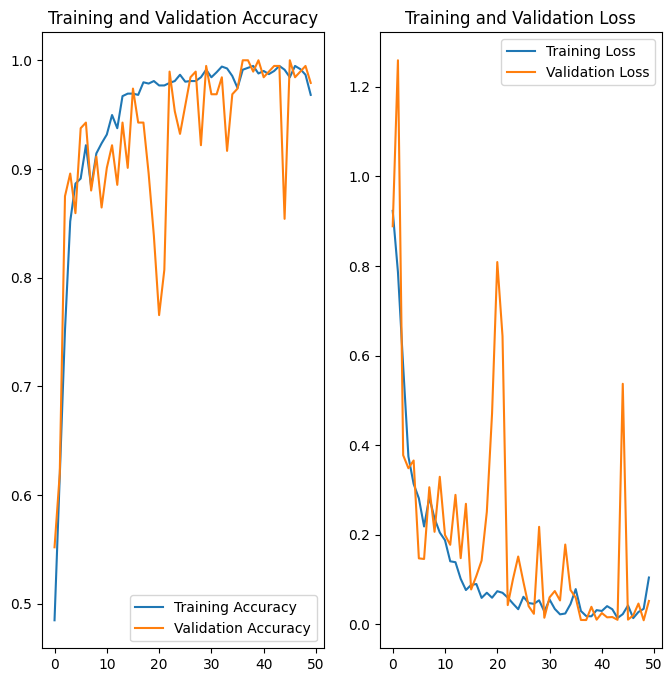

In [46]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 1s 1s/step
predicted label: Potato___Late_blight


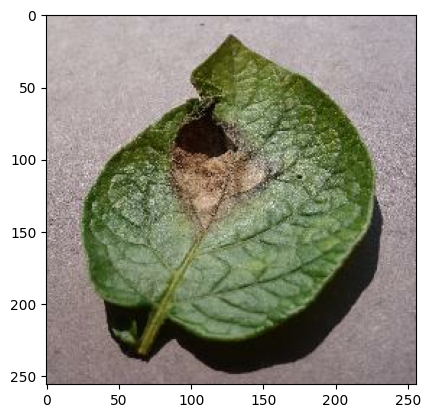

In [47]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [48]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 51ms/step


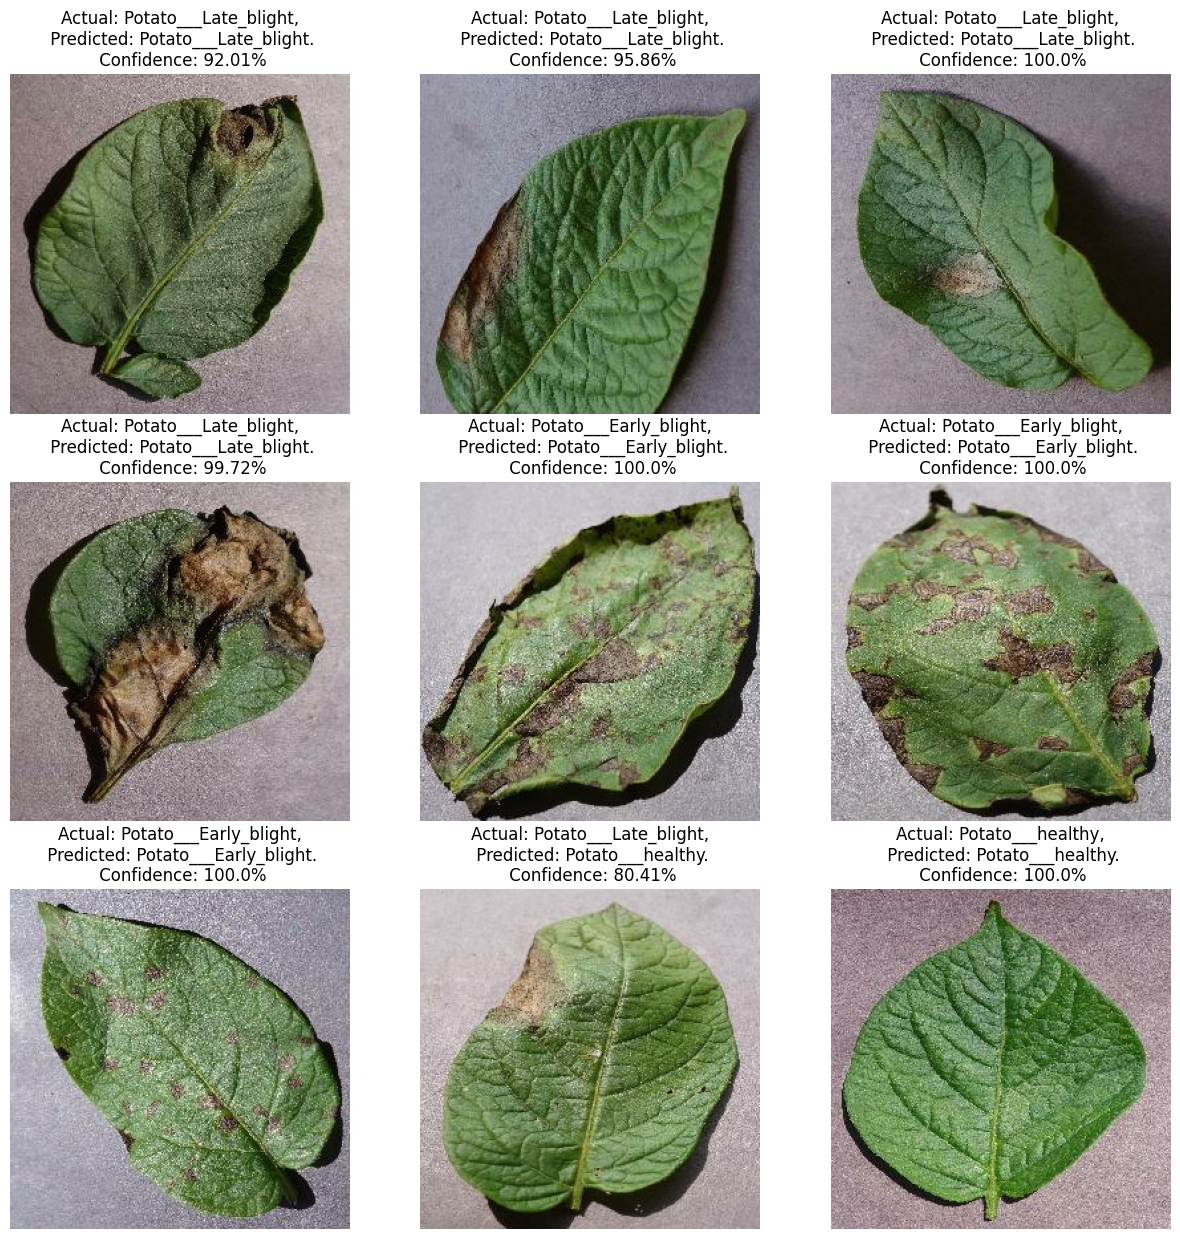

In [49]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [53]:
import os
model_version=max([int(i) for i in os.listdir("./models") + [0]])+1
model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/1\assets


INFO:tensorflow:Assets written to: ./models/1\assets
